In [2]:
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

class DataFetcher:
    def __init__(self, h5_nist_path, db_spectrum):
        self.h5_nist_path = h5_nist_path
        self.db_spectrum = db_spectrum

    def get_nist_data(self, element, sp_num):
        try:
            with pd.HDFStore(self.h5_nist_path, mode='r') as store:
                df = store['/spectrum_data']
                filtered = df[
                    (df['element'].str.strip().str.lower() == element.lower()) &
                    (df['sp_num'] == sp_num)
                ]
                return filtered[["obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k", "Acc"]].values.tolist()
        except Exception as e:
            print(f"Error accessing HDF5 file: {e}")
            return []

    def get_experimental_data(self, sample_name, iteration):
        import sqlite3
        conn = sqlite3.connect(self.db_spectrum)
        query = """
            SELECT wavelength, intensity
            FROM spectrum_data
            WHERE sample_name = ? AND iteration = ?
            ORDER BY wavelength
        """
        data = conn.execute(query, (sample_name, iteration)).fetchall()
        conn.close()
        if not data:
            return np.array([]), np.array([])
        wavelengths, intensities = zip(*data)
        return np.array(wavelengths, dtype=float), np.array(intensities, dtype=float)

    def get_peak_data(self, sample_name):
        excel_file = f"da/{sample_name}.xlsx"
        try:
            df = pd.read_excel(excel_file)
            return df
        except FileNotFoundError:
            print(f"Excel file not found: {excel_file}")
            return pd.DataFrame()
        except Exception as e:
            print(f"Error reading Excel file: {e}")
            return pd.DataFrame()

class SpectrumSimulator:
    def __init__(self, nist_data, temperature, resolution=24880):
        self.nist_data = nist_data
        self.temperature = temperature
        self.resolution = int(resolution)

    @staticmethod
    def partition_function(energy_levels, degeneracies, T):
        k_B = 8.617333262145e-5
        Z = np.sum([g * np.exp(-E / (k_B * T)) for g, E in zip(degeneracies, energy_levels)])
        return Z

    @staticmethod
    def calculate_intensity(T, energy, degeneracy, einstein_coeff, Z):
        k_B = 8.617333262145e-5
        return (degeneracy * np.exp(-energy / (k_B * T)) * einstein_coeff) / Z

    @staticmethod
    def gaussian_profile(x, center, sigma):
        return np.exp(-0.5 * ((x - center) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

    def simulate(self):
        wavelengths = np.linspace(200, 900, self.resolution)
        intensities = np.zeros_like(wavelengths)
        energy_levels = []
        degeneracies = []
        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek, Ei = float(Ek), float(Ei)
                    Ek = Ek / 8065.544
                    Ei = Ei / 8065.544
                    gi = float(gi)
                    gk = float(gk)
                    energy_levels.extend([Ei, Ek])
                    degeneracies.extend([gi, gk])
                except ValueError:
                    continue
        Z = self.partition_function(energy_levels, degeneracies, self.temperature)
        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek = float(Ek) / 8065.544
                    gi = float(gi)
                    gk = float(gk)
                    Aki = gA / gk
                    intensity = self.calculate_intensity(self.temperature, Ek, gk, Aki, Z)
                    sigma = 0.1
                    intensities += intensity * self.gaussian_profile(wavelengths, wl, sigma)
                except ValueError:
                    continue
        if intensities.size > 0:
            intensities = intensities / np.max(intensities)
        return wavelengths, intensities

def baseline_als(intensities, lam, p, niter):
    lam = lam * 1e4
    L = len(intensities)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * intensities)
        w = p * (intensities > z) + (1 - p) * (intensities < z)
    return z


In [12]:
import matplotlib.pyplot as plt

def plot_simulated_spectrum(h5_path, element, sp_num, temperature):
    # Inisialisasi DataFetcher
    fetcher = DataFetcher(h5_nist_path=h5_path, db_spectrum=None)
    
    # Ambil data NIST
    nist_data = fetcher.get_nist_data(element=element, sp_num=sp_num)
    if not nist_data:
        print("Data tidak ditemukan untuk elemen tersebut.")
        return

    # Simulasi spektrum
    simulator = SpectrumSimulator(nist_data=nist_data, temperature=temperature)
    wavelengths, intensities = simulator.simulate()

    # Menggunakan style 'seaborn' agar plot lebih ilmiah
    plt.style.use('ggplot')

    plt.figure(figsize=(12, 5))
    plt.plot(wavelengths, intensities, color='blue', lw=1, label='Simulasi')
    plt.title(f"Simulasi Spektrum {element} pada {temperature}K")
    plt.xlabel("Panjang Gelombang (nm)")
    plt.ylabel("Intensitas (arb. unit)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

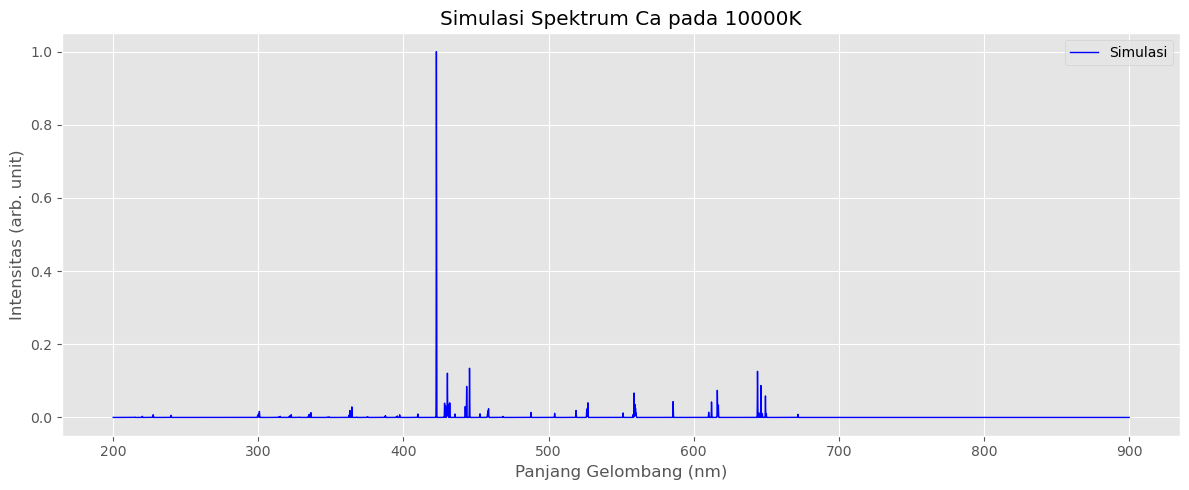

In [13]:
plot_simulated_spectrum(
    h5_path='/Users/birrulwldain/Documents/GitHub/skripsi-21/-data/HDF5/database_backup.h5',
    element='Ca',
    sp_num=1,
    temperature=10000
)
